# Pupil preprocessing

A tutorial by Jan Willem de Gee (jwdegee@gmail.com) and Tomas Knapen (tknapen@gmail.com)

In [32]:
import pandas as pd
%pylab
import seaborn as sns
%matplotlib inline
from scipy import signal
from lmfit import minimize, Parameters, Parameter, report_fit
import fir

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


Let's load some raw pupil data.

EyeSignalOperator expects an inputObject that is a dictionary with keys "timepoints", "gazeXY", "pupil" and the corresponding timeseries as values. Additionally, we can (but don't have to) pass a dictionary called "eyelink_blink_data" and "eyelink_sac_data". 

In [33]:
sample_rate = 1000.0
eye_dict = pd.read_csv('data/eye_dict.csv')
blink_dict = pd.read_csv('data/blink_dict.csv')
sac_dict = pd.read_csv('data/sac_dict.csv')

# variables to work with:
start_time = eye_dict.timepoints[0]
timepoints = eye_dict.timepoints - start_time
pupil = eye_dict.pupil
blink_starts = np.array(blink_dict.start_timestamp - start_time, dtype=int)
blink_ends = np.array(blink_dict.end_timestamp - start_time, dtype=int)
sac_starts = np.array(sac_dict.start_timestamp - start_time, dtype=int)
sac_ends = np.array(sac_dict.end_timestamp - start_time, dtype=int)

Let's plot the raw pupil timeseries:

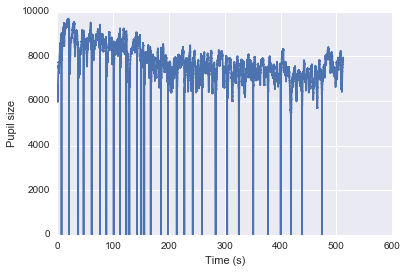

In [34]:
x = timepoints / sample_rate
plot(x, pupil)
xlabel('Time (s)')
ylabel('Pupil size')

The periods where the timeseries drop to 0 correspond to blinks. Let's linearly interpolate these blinks.

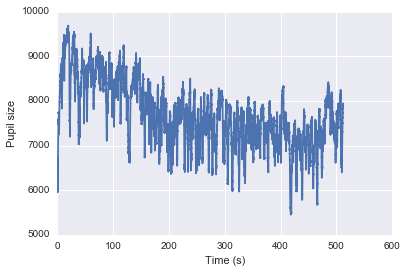

In [35]:
margin = 100 # ms
pupil_interpolated = np.array(pupil.copy())
for b in range(len(blink_starts)):
    blink_start = blink_starts[b] - margin
    blink_end = blink_ends[b] + margin
    interpolated_signal = np.linspace(pupil_interpolated[blink_start], 
                                      pupil_interpolated[blink_end],
                                      blink_end-blink_start)
    pupil_interpolated[blink_start:blink_end] = interpolated_signal
    
plot(x, pupil_interpolated)
xlabel('Time (s)')
ylabel('Pupil size')

To see what happened, let's zoom in on one interpolated blink:

87.719
87.828


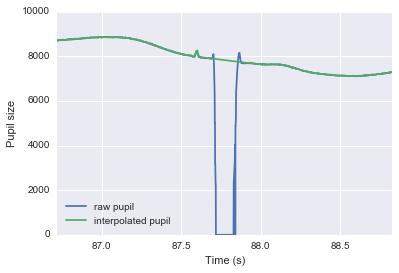

In [36]:
plot(x, pupil, label='raw pupil')
plot(x, pupil_interpolated, label='interpolated pupil')
xlim((blink_starts[7] - 1000) / sample_rate, 
     (blink_ends[7] + 1000) / sample_rate)
xlabel('Time (s)')
ylabel('Pupil size')
legend(loc=3)

print blink_starts[7] / sample_rate
print blink_ends[7] / sample_rate

Let's filter blink interpolated pupil timeseries now. We'll construct a low pass (<10Hz), and a band-pass (0.01-10Hz) signal. And again, let's plot the results.

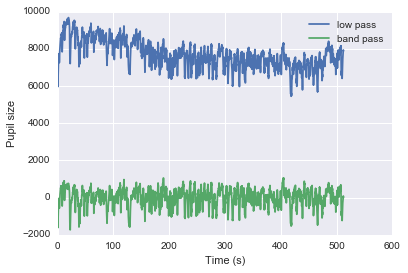

In [37]:
hp = 0.01
lp = 10.0

# High pass:
hp_cof_sample = hp / (len(pupil_interpolated) / sample_rate / 2)
bhp, ahp = signal.butter(3, hp_cof_sample, btype='high')
pupil_interpolated_hp = signal.filtfilt(bhp, ahp, pupil_interpolated)
# Low pass:
lp_cof_sample = lp / (len(pupil_interpolated) / sample_rate / 2)
blp, alp = signal.butter(3, lp_cof_sample)
pupil_interpolated_lp = signal.filtfilt(blp, alp, pupil_interpolated)
# Band pass:
pupil_interpolated_bp = signal.filtfilt(blp, alp, pupil_interpolated_hp)

plot(x, pupil_interpolated_lp, label='low pass')
plot(x, pupil_interpolated_bp, label='band pass')
xlabel('Time (s)')
ylabel('Pupil size')
legend()

The band-pass filtered signal we can use now to estimate pupil responses to blinks and saccades. You can think of these of simple event related averages. However, to account for temporally adjacent event, and hence overlapping responses (due to slow pupil IRF), here we will rely on deconvolution. 

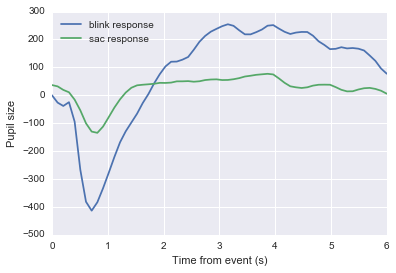

In [38]:
downsample_rate = 100
new_sample_rate = sample_rate / downsample_rate
interval = 6

# events:
events = [(blink_ends / sample_rate), 
          (sac_ends / sample_rate)]

# compute blink and sac kernels with deconvolution (on downsampled timeseries):
a = fir.FIRDeconvolution(signal=signal.decimate(pupil_interpolated_bp, downsample_rate, 1), 
                         events=events, event_names=['blinks', 'sacs'], sample_frequency=new_sample_rate, 
                         deconvolution_frequency=new_sample_rate, deconvolution_interval=[0,interval],)
a.create_design_matrix()
a.regress()
a.betas_for_events()
blink_response = np.array(a.betas_per_event_type[0]).ravel()
sac_response = np.array(a.betas_per_event_type[1]).ravel()

# baseline the kernels:
blink_response = blink_response - blink_response[0].mean()
sac_response = sac_response - blink_response[0].mean()

# plot:
x = np.linspace(0, interval, len(blink_response))
plot(x, blink_response, label='blink response')
plot(x, sac_response, label='sac response')
xlabel('Time from event (s)')
ylabel('Pupil size')
legend(loc=2)

Let's fit kernels to these:

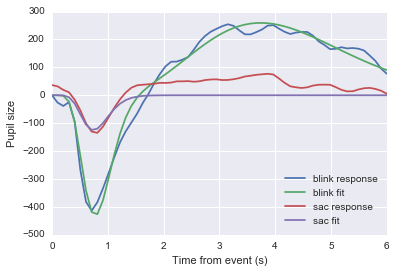

In [39]:
def single_pupil_IRF(params, x):
    s1 = params['s1']
    n1 = params['n1']
    tmax1 = params['tmax1']
    return s1 * ((x**n1) * (np.e**((-n1*x)/tmax1)))

def single_pupil_IRF_ls(params, x, data):
    s1 = params['s1'].value
    n1 = params['n1'].value
    tmax1 = params['tmax1'].value
    model = s1 * ((x**n1) * (np.e**((-n1*x)/tmax1)))
    return model - data

def double_pupil_IRF(params, x):
    s1 = params['s1']
    s2 = params['s2']
    n1 = params['n1']
    n2 = params['n2']
    tmax1 = params['tmax1']
    tmax2 = params['tmax2']
    return s1 * ((x**n1) * (np.e**((-n1*x)/tmax1))) + s2 * ((x**n2) * (np.e**((-n2*x)/tmax2)))

def double_pupil_IRF_ls(params, x, data):
    s1 = params['s1'].value
    s2 = params['s2'].value
    n1 = params['n1'].value
    n2 = params['n2'].value
    tmax1 = params['tmax1'].value
    tmax2 = params['tmax2'].value
    model = s1 * ((x**n1) * (np.e**((-n1*x)/tmax1))) + s2 * ((x**n2) * (np.e**((-n2*x)/tmax2)))
    return model - data

# create a set of Parameters
params = Parameters()
params.add('s1', value=-1, min=-np.inf, max=-1e-25)
params.add('s2', value=1, min=1e-25, max=np.inf)
params.add('n1', value=10, min=9, max=11)
params.add('n2', value=10, min=8, max=12)
params.add('tmax1', value=0.9, min=0.5, max=1.5)
params.add('tmax2', value=2.5, min=1.5, max=4)

# do fit, here with powell method:
blink_result = minimize(double_pupil_IRF_ls, params, method='powell', args=(x, blink_response))
blink_kernel = double_pupil_IRF(blink_result.params, x)
sac_result = minimize(single_pupil_IRF_ls, params, method='powell', args=(x, sac_response))
sac_kernel = single_pupil_IRF(sac_result.params, x)

# plot:
plot(x, blink_response, label='blink response')
plot(x, blink_kernel, label='blink fit')
plot(x, sac_response, label='sac response')
plot(x, sac_kernel, label='sac fit')
xlabel('Time from event (s)')
ylabel('Pupil size')
legend(loc=4)

Now, with a GLM let's resgress these responses to blinks and saccades from our pupil timeseries. 

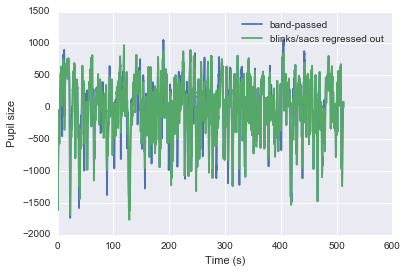

In [40]:
# upsample:
x = np.linspace(0, interval, interval*sample_rate)
blink_kernel = double_pupil_IRF(blink_result.params, x)
sac_kernel = double_pupil_IRF(sac_result.params, x)

# regressors:
blink_reg = np.zeros(len(pupil))
blink_reg[blink_ends] = 1
blink_reg_conv = signal.fftconvolve(blink_reg, blink_kernel, 'full')[:-(len(blink_kernel)-1)]
sac_reg = np.zeros(len(pupil))
sac_reg[blink_ends] = 1
sac_reg_conv = signal.fftconvolve(sac_reg, sac_kernel, 'full')[:-(len(sac_kernel)-1)]
regs = [blink_reg_conv, sac_reg_conv]

# GLM:
design_matrix = np.matrix(np.vstack([reg for reg in regs])).T
betas = np.array(((design_matrix.T * design_matrix).I * design_matrix.T) * np.matrix(pupil_interpolated_bp).T).ravel()
explained = np.sum(np.vstack([betas[i]*regs[i] for i in range(len(betas))]), axis=0)

# clean pupil:
pupil_clean_bp = pupil_interpolated_bp - explained

# plot:
x = timepoints / sample_rate 
plot(x, pupil_interpolated_bp, label='band-passed')
plot(x, pupil_clean_bp, label='blinks/sacs regressed out')
xlabel('Time (s)')
ylabel('Pupil size')
legend()

Finally, let's add back the slow drift, which is meaningfull part of the signal!

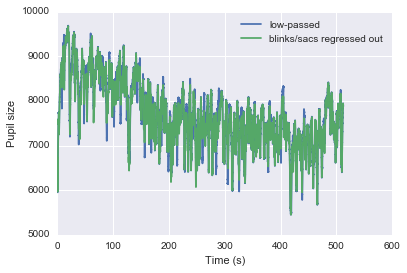

In [41]:
pupil_clean_lp = pupil_clean_bp + (pupil_interpolated_lp-pupil_interpolated_bp)
plot(x, pupil_interpolated, label='low-passed')
plot(x, pupil_clean_lp, label='blinks/sacs regressed out')
xlabel('Time (s)')
ylabel('Pupil size')
legend()